# ABTS Small Laccase from *Streptomyces coelicolor*

In this data set, 

All data except for measurement data was entered into an EnzymeML Excel-template. Therein, concentration information of the enzyme and initial substrate was specified. All other information was parsed from the .txt output of the photometer.

In [2]:
%load_ext autoreload
%autoreload 2
from typing import Dict, List
import pyenzyme as pe
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from lmfit import Parameters, minimize
from scipy.stats import linregress
from joblib import Parallel, delayed
from CaliPytion.tools.standardcurve import StandardCurve
from EnzymePynetics.tools.parameterestimator import ParameterEstimator

# Custom functions for data mapping
from parser_functions import measurement_data_to_EnzymeML
from parser_functions import read_measurement_data, read_calibration_data

import warnings
warnings.filterwarnings('ignore')

## 1. Data preparation

The first measurement in each dataset represents a control reaction with 0 mM ABTS. Therefore, the mean value of measurements without substrate is used to blanc the data by subtracting it from all measurement data. Afterwards, the control reaction is deleted from the dataset.

In [3]:
directory_measurement_data = "../../data/SLAC_kinetic_characterization/TimeCourseData"
directory_standard_data = "../../data/SLAC_kinetic_characterization/StandardData"
directory_spectrum_data = "../../data/SLAC_kinetic_characterization/SpectrumData"

# Parse measurement data from photometer output
raw_data_dict = {}
for path in os.listdir(directory_measurement_data):
    data = read_measurement_data(f"{directory_measurement_data}/{path}")
    pH = data["pH"]
    temp = data["temperature"]
    raw_data_dict[f"{pH} {temp}"] = data

In [4]:
path_EnzymeML_template = "../../data/SLAC_kinetic_characterization/EnzymeML_SLAC_empty.xlsm"

# Define IDs for species, listed in the EnzymeML-template
substrate_id = "s0"
product_id = "s1"
substrate_control_id = "s2"
product_control_id = "s3"
species_ids = [substrate_id, product_id, substrate_control_id, product_control_id]


# Write data to EnzymeMLDocument
absortion_enzymemldocs: List[pe.EnzymeMLDocument] = []
for name, data in raw_data_dict.items():
    absortion_enzymemldocs.append(measurement_data_to_EnzymeML(
        template_path=path_EnzymeML_template,
        measurement_data=data,
        species_ids=species_ids,
        data_unit="umole / l",
        time_unit="s"))


absortion_enzymemldocs = sorted(absortion_enzymemldocs, key=lambda x: (x.getReaction("r0").ph, x.getReaction("r0").temperature))

### 1.1 Blanking of absorption data

In [4]:
# Blanc measurement data
for enzmldoc in absortion_enzymemldocs:
    blanc_measurement = enzmldoc.measurement_dict["m0"].getReactant("s0").replicates
    blanc = np.mean([repeat.data for repeat in blanc_measurement])

    for id, measurement in enzmldoc.measurement_dict.items():
        for rep, replicate in enumerate(measurement.getReactant("s0").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s0").replicates[rep].data = blanced_data
        for rep, replicate in enumerate(measurement.getReactant("s2").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s2").replicates[rep].data = blanced_data
    
    # Delete blanking measurement 'm0'
    del enzmldoc.measurement_dict["m0"]

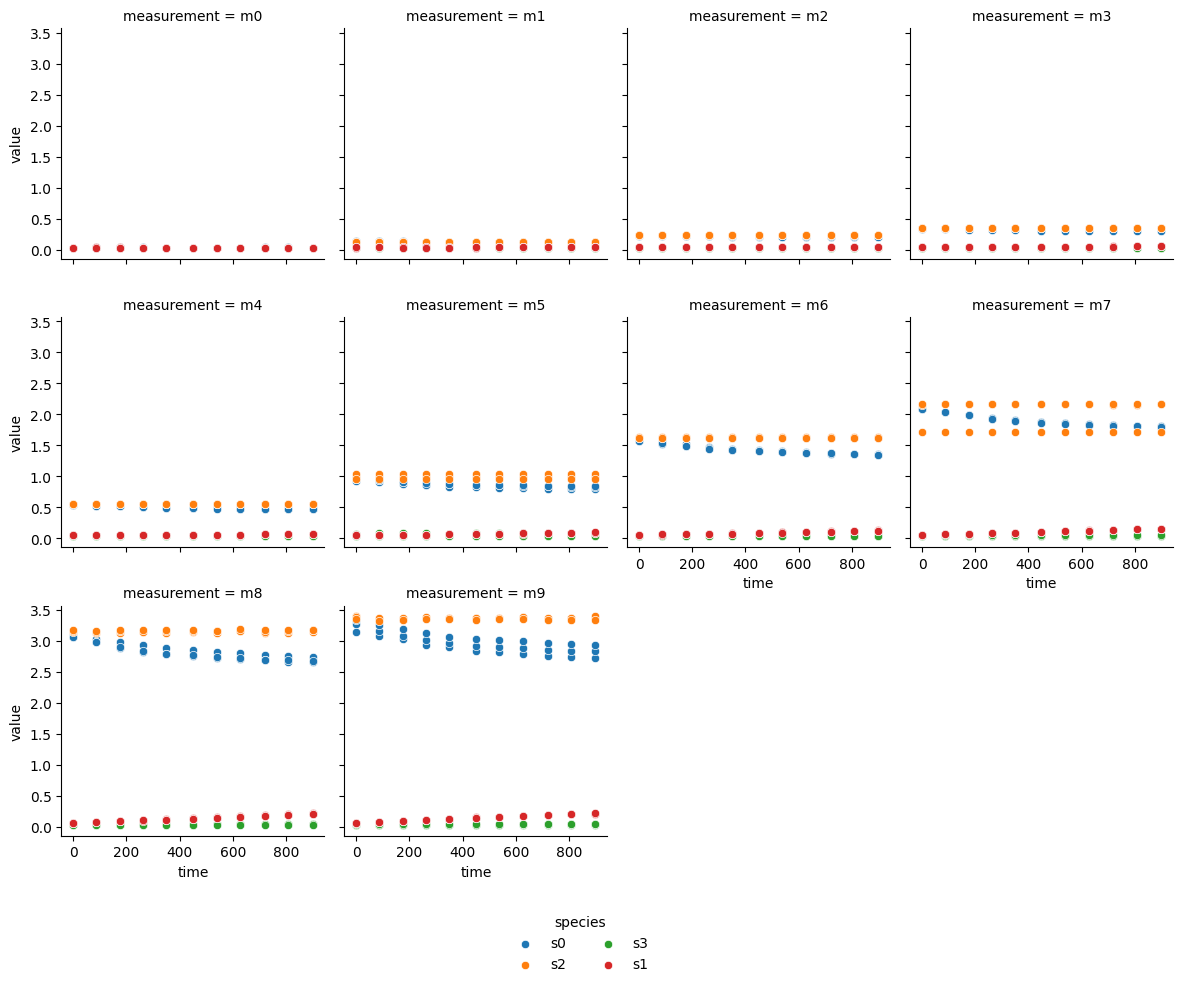

In [5]:
absortion_enzymemldocs[14].visualize()
plt.show()

### 1.2 Application of calibration data

In [6]:
# Script to load calibration raw-data

calibration_data = []
standard_directory = np.sort(os.listdir(directory_standard_data))
spectrum_directory = np.sort(os.listdir(directory_spectrum_data))

for standard, spectrum in zip(standard_directory, spectrum_directory):
    standard = f"{directory_standard_data}/{standard}"
    spectrum = f"{directory_spectrum_data}/{spectrum}"
    result = read_calibration_data(
        path_standard=standard,
        path_spectrum=spectrum,
        species_id=substrate_id,
        wavelengths=[340, 420],
        concentrations=[0,5,10,15,25,50,75,100,125,150,175,200],
        concentration_unit="umole / l",
        device_manufacturer="MANUFACTURER",
        device_model="SUPERMODEL",
        spectrum_reactant_concentration=69
    )
    for pH in result.keys():
        calibration_data.append(result[pH])

calibration_data = sorted(calibration_data, key = lambda x: (x.pH, x.temperature))

# Generate standard curves for ABTS calibration data
standard_curves: List[StandardCurve] = []
for calibration in list(calibration_data):
    standard_curves.append(StandardCurve(calibration_data=calibration, wavelength=340, cutoff_absorption=3, show_output=False))

# Sort standard curves by ascending pH and temperature.
standard_curves = sorted(standard_curves, key = lambda x: (x.calibration_data.pH, x.calibration_data.temperature))

Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatically blanked.
Calibration data was automatical

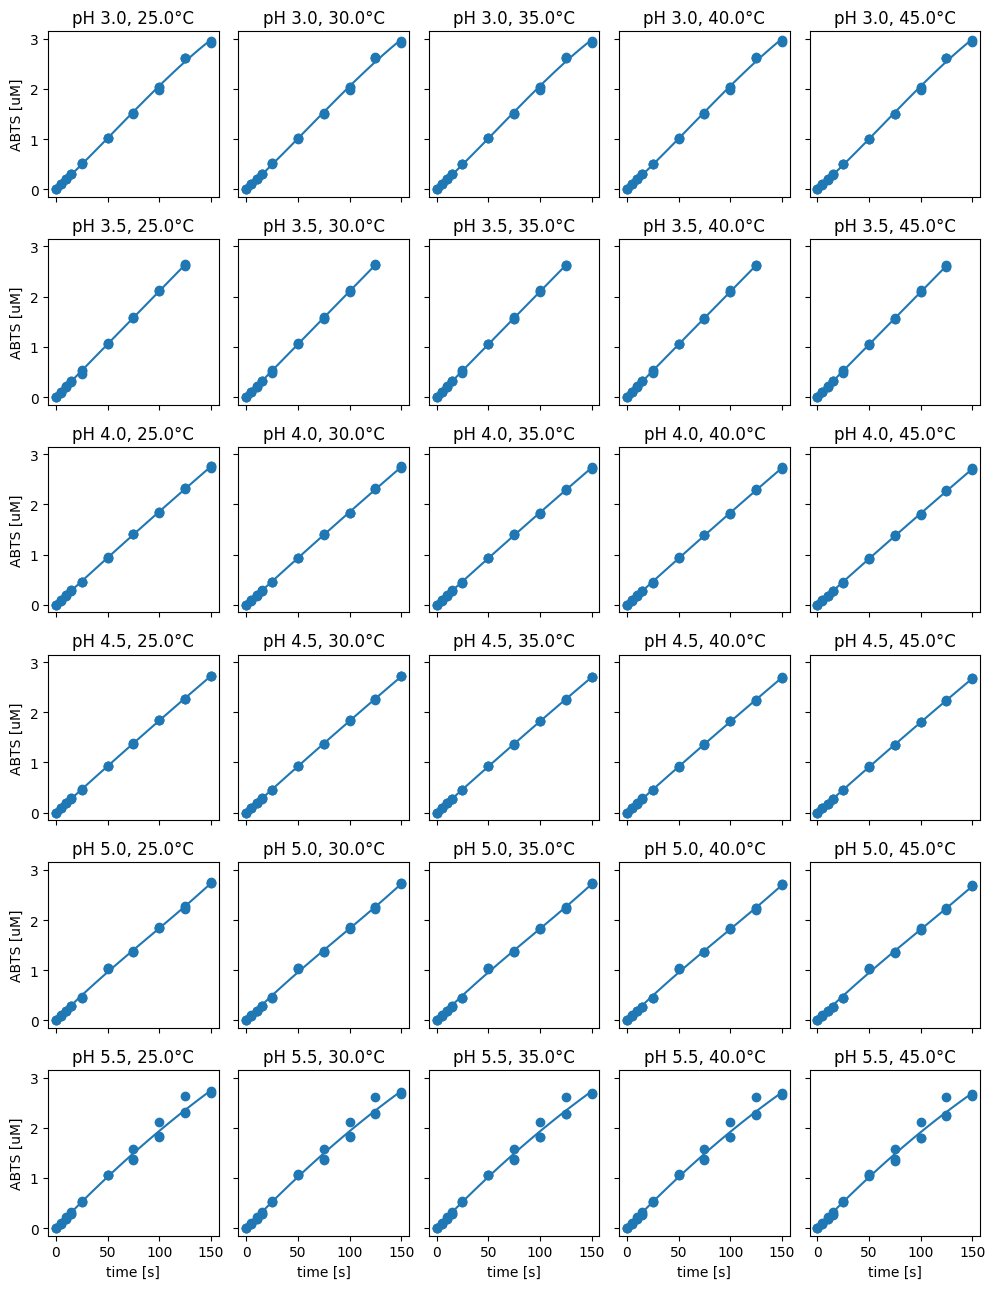

In [7]:
# Visualize all fitted standard curves 

fig, axes = plt.subplots(6,5, figsize=(10, 13), sharey=True, sharex=True)
for i, (standard, ax) in enumerate(zip(standard_curves[:30], axes.flatten())):
    if not i%5:
        ax.set_ylabel("ABTS [uM]")
    standard.visualize(ax=ax)
    ax.set_title(f"pH {standard.calibration_data.pH}, {standard.calibration_data.temperature}°C")
    if i in [25,26,27,28,29]:
        ax.set_xlabel("time [s]")
plt.tight_layout()

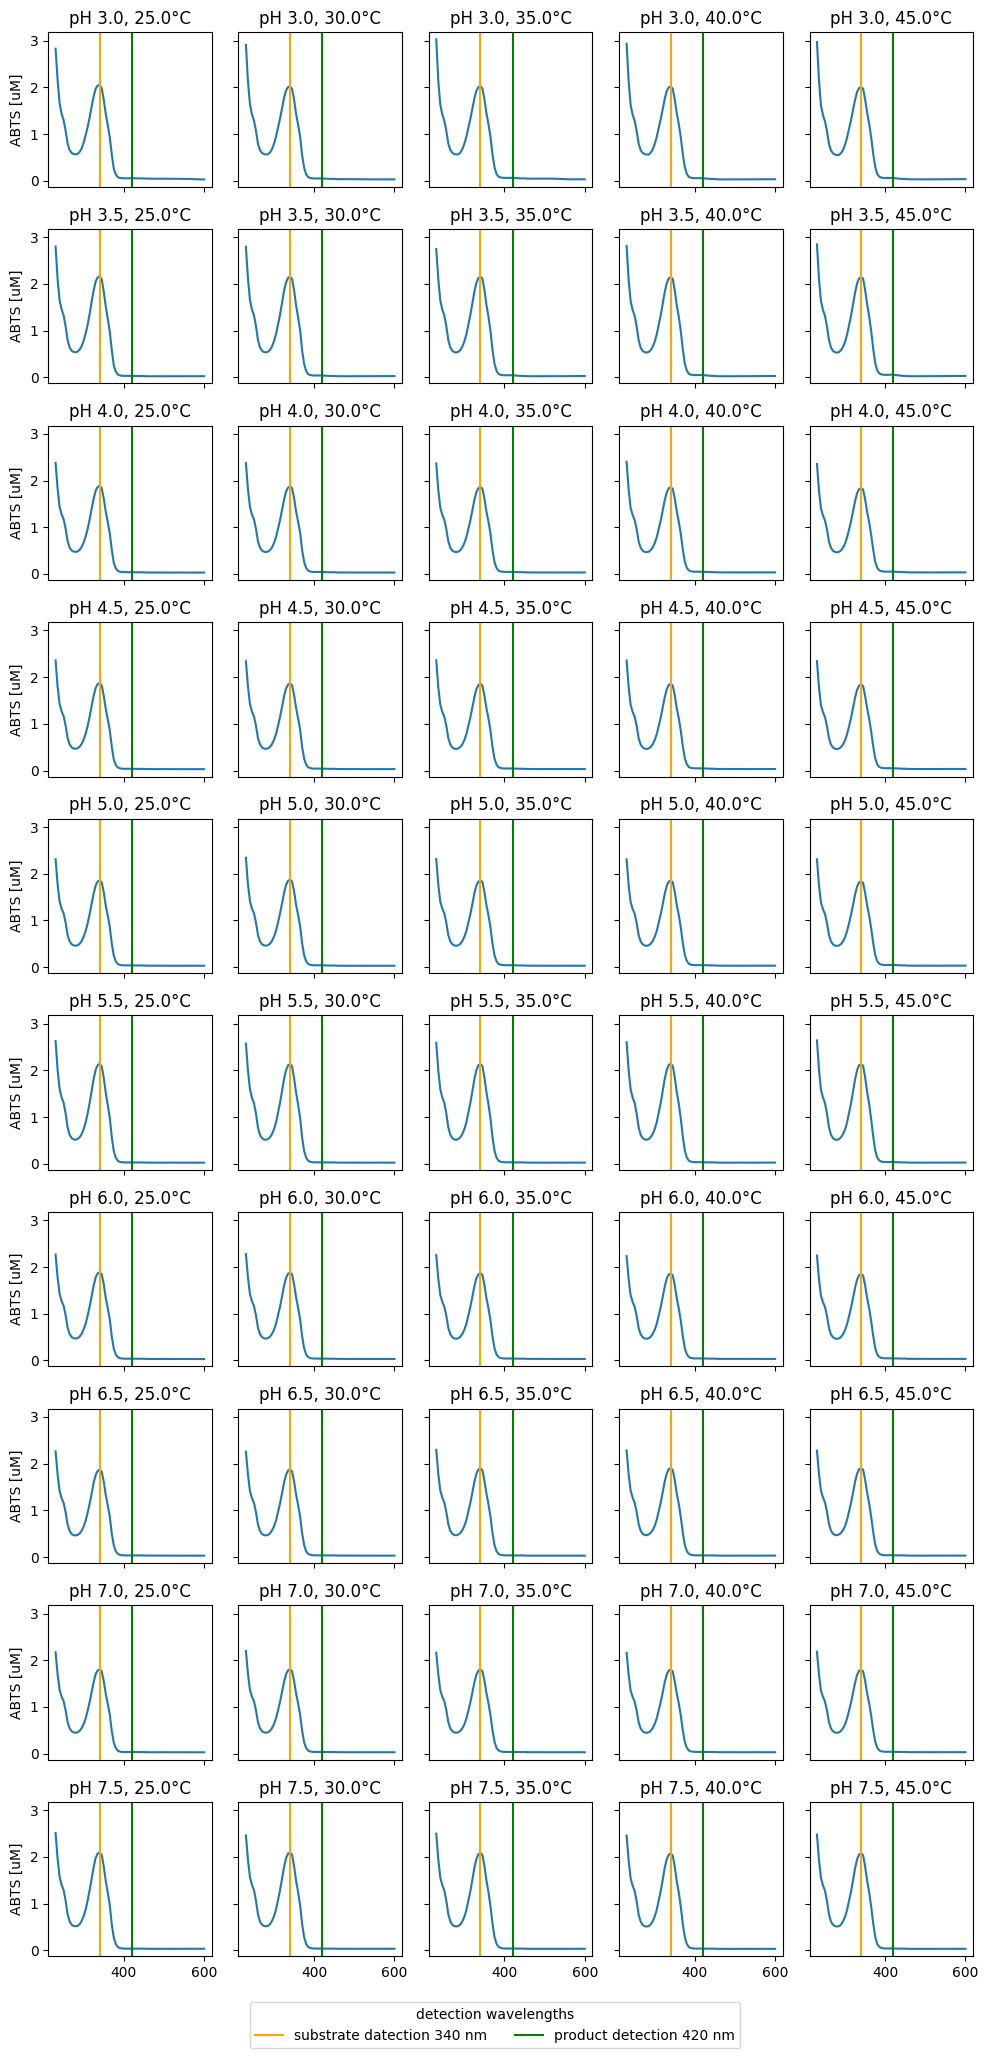

In [8]:
fig, axes = plt.subplots(10,5, figsize=(10, 20), sharey=True, sharex=True)
for i, (doc, ax) in enumerate(zip(calibration_data, axes.flatten())):
    if not i%5:
        ax.set_ylabel("ABTS [uM]")
    ax.plot(doc.spectrum.wavelength, doc.spectrum.absorption[0].values)
    ax.axvline(340, color="orange", label="substrate datection 340 nm")
    ax.axvline(420, color="green", label="product detection 420 nm")
    ax.set_title(f"pH {doc.pH}, {doc.temperature}°C")
    if i in [100]:
        ax.set_xlabel("wavelength [nm]")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="detection wavelengths", bbox_to_anchor=(0.5,-0.03))
plt.tight_layout()


In [9]:
path= "/Users/maxhaussler/Dropbox/master_thesis/data/alaric/2022-10-04 - ABTS Radical Spectrum 230-600nm.xlsx"
spectrum_df = pd.read_excel(path)


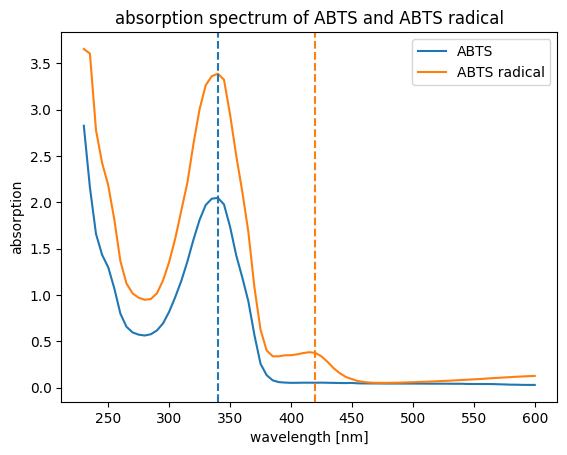

In [10]:
cmap = matplotlib.cm.get_cmap('tab20')


doc = calibration_data[0] 
plt.plot(doc.spectrum.wavelength, doc.spectrum.absorption[0].values, color=cmap(0.0), label="ABTS")
plt.plot(spectrum_df["wavelength"], spectrum_df["absorption"], color=cmap(0.1), label="ABTS radical")
plt.axvline(340, color=cmap(0.0), linestyle ="--")
plt.axvline(420, color=cmap(0.1), linestyle ="--")

plt.ylabel("absorption")
plt.xlabel("wavelength [nm]")
plt.legend()
plt.title("absorption spectrum of ABTS and ABTS radical")
plt.show()

In [9]:
# Calculate concentrations by applying standard curves to 'EnzymeMLDocuments'.
concentration_enzymemldocs = []
for standard_curve, abso_enzmldoc in zip(standard_curves, absortion_enzymemldocs):

    # Validate, that measurement data is paired with respective standard curve
    assert standard_curve.calibration_data.pH == abso_enzmldoc.getReaction("r0").ph
    assert standard_curve.calibration_data.temperature == abso_enzmldoc.getReaction("r0").temperature

    enzmldoc = copy.deepcopy(abso_enzmldoc)
    conc_enzmldoc = standard_curve.apply_to_EnzymeML(enzmldoc, "s0", ommit_nan_measurements=True)
    conc_enzmldoc = standard_curve.apply_to_EnzymeML(enzmldoc, "s2", ommit_nan_measurements=True)

    concentration_enzymemldocs.append(conc_enzmldoc)

Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m8', 'm9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m8', 'm9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m8', 'm9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m8', 'm9']' removed from document, since respective measurement values are out

### 1.3 Kinetic parameter estimantion

In [ ]:
# Run parameter estimator for all datasets, utilizing multi-processing.
def run_ParameterEstimator(enzmldoc: pe.EnzymeMLDocument):    
    kinetics = ParameterEstimator.from_EnzymeML(enzmldoc, "s0", "substrate")
    kinetics.fit_models(enzyme_inactivation=True, only_irrev_MM=True, display_output=False)
    return kinetics

results = Parallel(n_jobs=8)(delayed(run_ParameterEstimator)(enzmldoc) for enzmldoc in concentration_enzymemldocs)

## 2. Results

### 2.1 Quality control through mass balance analysis

ABTS absorbs at 340 nm whereas ABTS radical, the reaction product, is known to absorb at 420 nm [REFERENCE]. In contrast to the substrate, no calibration standard is available for the product.
Nevertheless, product build-up was followd beside substrate depletion over the time-course of the reaction. Therefore, the following mass balance equation can be established under the assumption of mass conservation:  
$0 = S_{(t)} + P_{(t)} - S_{0}$

Thereby, substrate absorbance signals were converted into concentrations by using the respective standard curve. Product concentration was determined, assuming a linear relationship between absorption and concentration. Thus, the parameter $k$ was introduced to the mass balance equation:  
$0 = S_{(t)} + P_{(t)}k - S_{0}$

In the following cell, $k$ is determined for each assay seperately, by minimizing the slope of each time-course measurement of the assay. 

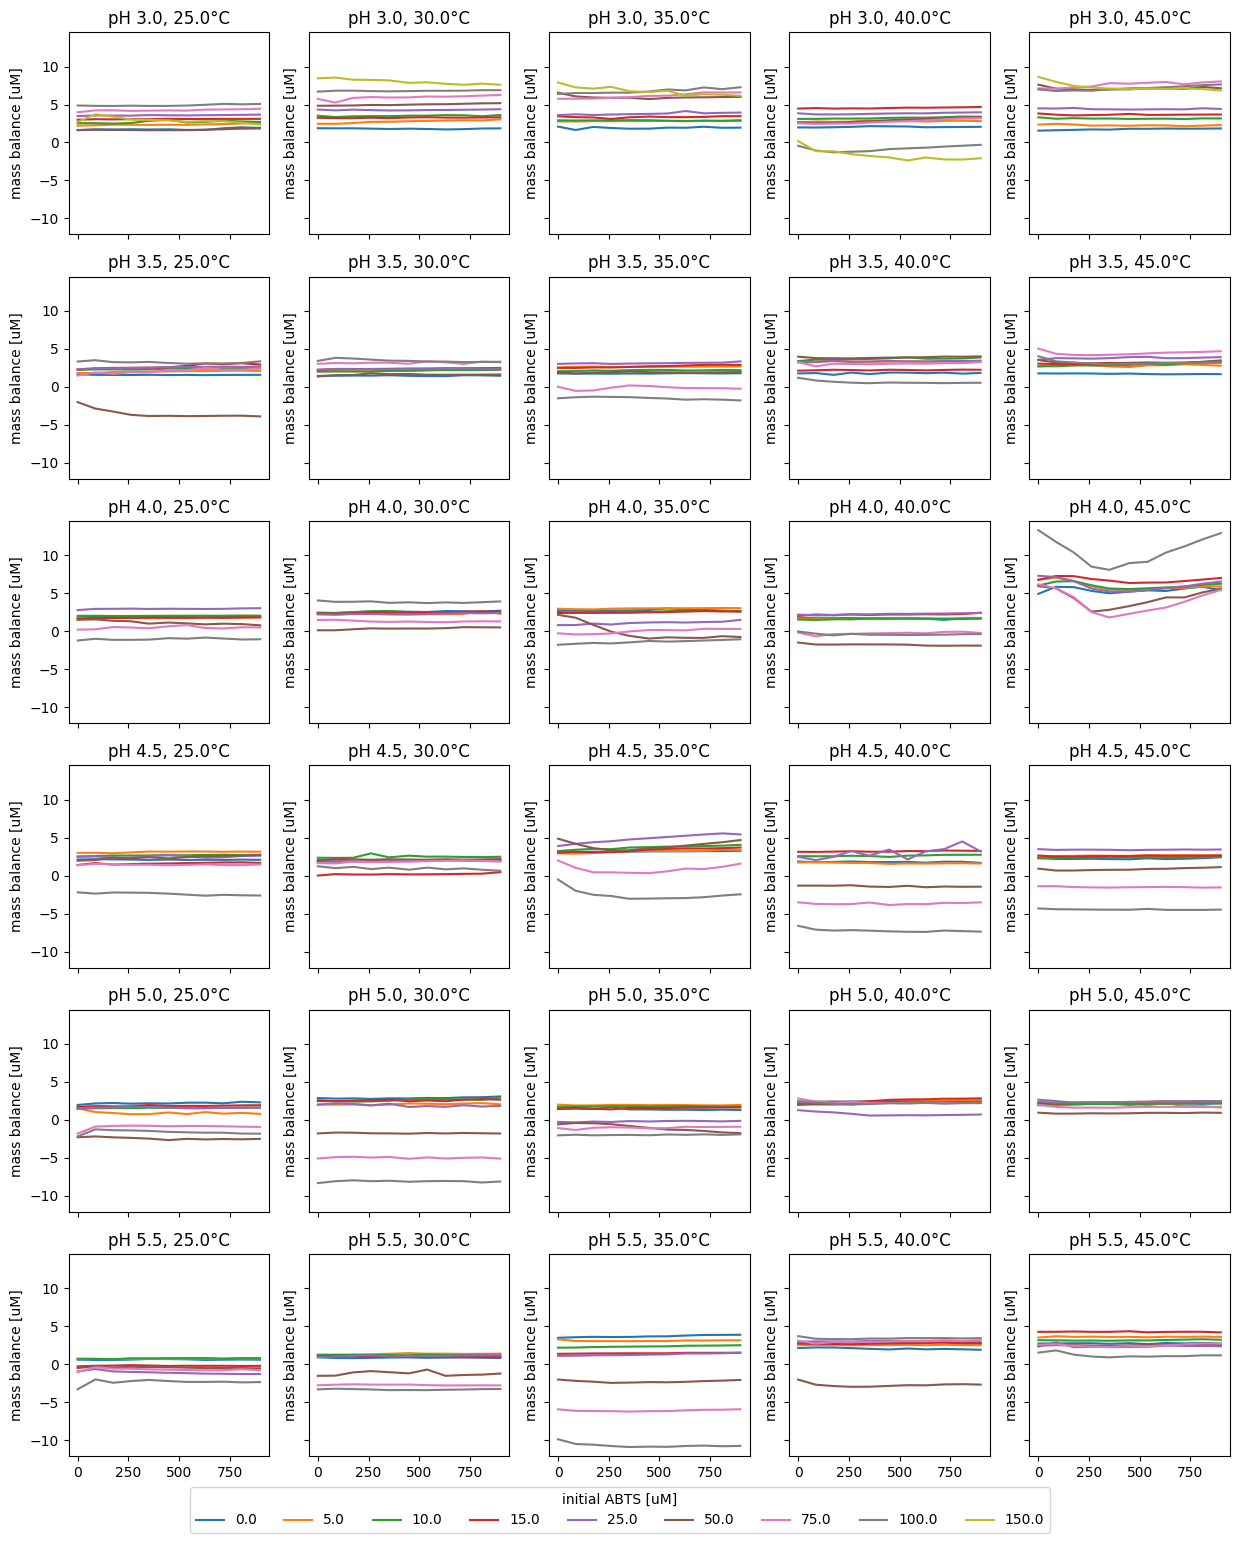

In [10]:
# Defenition of parameter 'k'
params = Parameters()
params.add("k", value=30, min=0, max=200)

# Target function for the minimizer
def residual(params, x):
    k=params["k"]

    substrate, product,  control = x
    slopes = substrate[:,0] * 0.0
    for i, (s, p, c) in enumerate(zip(substrate, product, control)):
        sub = np.mean(s, axis=0)
        prod = np.mean(p, axis=0)
        cont = np.mean(c, axis=0)

        model = sub + prod*k - cont

        slopes[i] = linregress(np.arange(len(model)), model)[0]

    return slopes.flatten()


f = []
fig, axes = plt.subplots(6,5, figsize=(12.5, 15), sharey=True, sharex=True)
for e, (doc, ax) in enumerate(zip(concentration_enzymemldocs, axes.flatten())):
    substrate = []
    product = []
    initial_substrate = []
    control = []
    for measurement in doc.measurement_dict.values():
        initial_substrate.append(measurement.getReactant(substrate_id).init_conc)
        for replicate in measurement.getReactant(substrate_id).replicates:
            substrate.append(replicate.data)
        for replicate in measurement.getReactant(product_id).replicates:
            product.append(replicate.data)
        for replicate in measurement.getReactant("s2").replicates:
            control.append(replicate.data)

    time = np.array(replicate.time)

    product = np.array(product).reshape(int(len((product))/3),3,11)
    substrate = np.array(substrate).reshape(int(len((substrate))/3),3,11)
    control = np.array(control).reshape(int(len((control))/3),3,11)
    initial_substrate = np.array(initial_substrate)

    x = (substrate, product, control)

    result = minimize(residual, params, args=(x,))

    factor = result.params["k"].value
    f.append(factor)

    for i, (s, p, c, l) in enumerate(zip(substrate, product,  control, initial_substrate)):
        init = np.mean(c, axis=0)
        sub = np.mean(s, axis=0)
        prod = np.mean(p, axis=0)
        cont = np.mean(c, axis=0)
        balance = (sub + prod*factor - cont)

        ax.plot(doc.getMeasurement("m1").getReactant("s0").replicates[0].time, balance, label = l)
        if not i%5:
            ax.set_ylabel("mass balance [uM]")
        if i in [24, 25, 26, 27, 28, 29]:
            ax.set_xlabel("time [s]")
        pH = doc.getReaction("r0").ph
        temp = doc.getReaction("r0").temperature
        ax.set_title(f"pH {pH}, {temp}°C")#, factor: {factor:.0f}")
    if e == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="initial ABTS [uM]", bbox_to_anchor=(0.5,-0.03))
plt.tight_layout()



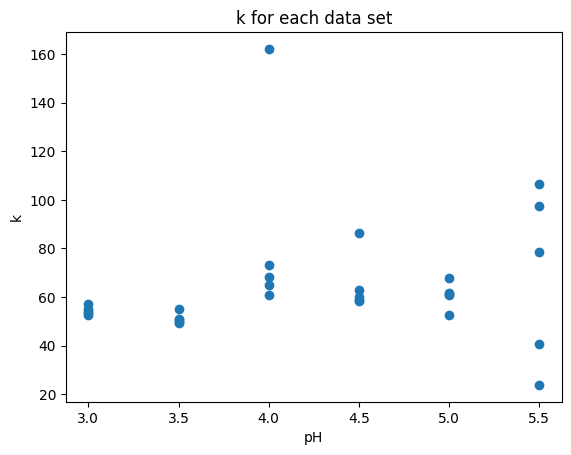

In [13]:
for doc, k in zip(concentration_enzymemldocs, f):

    ph = doc.getReaction("r0").ph
    plt.scatter(ph, k, color=cmap(0))
    old_ph = ph

plt.ylabel("k")
plt.xlabel("pH")
plt.title("k for each data set")
plt.show()

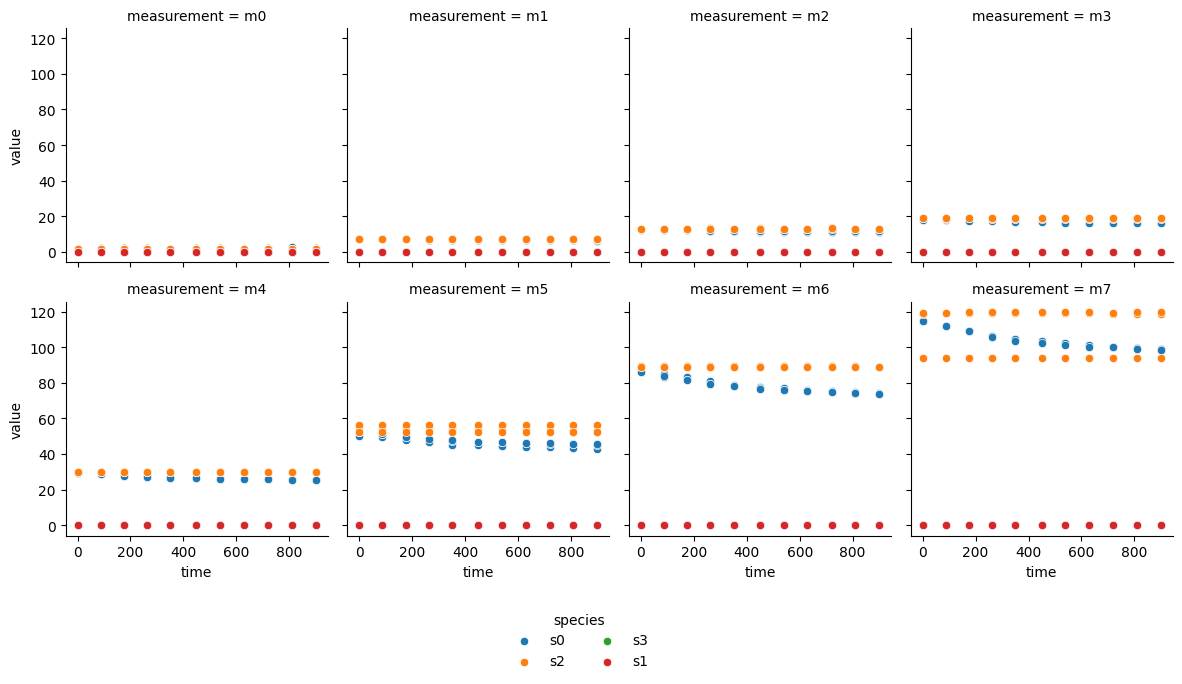

In [11]:
concentration_enzymemldocs[14].visualize()

Estimated parameters for the kinetic assay at pH 5.5 and 25°C were discarded from the dataset, since they reached the upper parameter limit for kcat and Km. Hence, it can be assumed, that the enzyme is not active at the given conditions.

In [16]:
results = sorted(results, key=lambda x: (x.data.pH, x.data.temperature))

# Get kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
ki = []
ki_std = []
pH = []
temperature = []
corr_kcat_km = []
for result in results:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)

    ki.append(params["K_ie"].value)
    ki_std.append(params["K_ie"].stderr)    

    
    correlation = params["k_cat"].correl
    if correlation == None:
        corr_kcat_km.append(float("nan"))
    else:
        corr_kcat_km.append(correlation["Km"])

    pH.append(result.data.pH)
    temperature.append(result.data.temperature)

df = pd.DataFrame.from_dict({
    'pH':pH, 
    "temperature":temperature, 
    'kcat [1/s]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [uM]':Km, 
    'Km stderr':Km_std, 
    "Enzyme inactivation [1/s]":ki,
    "Enzyme inactivation std":ki_std,
    "correlation kcat/Km":corr_kcat_km})

df["kcat/Km"] = df["kcat [1/s]"] / df["Km [uM]"]
kcat_km_stderr =((df["kcat stderr"]/df["kcat [1/s]"])**2+(df["Km stderr"]/df["Km [uM]"])**2)**0.5 * df["kcat/Km"]
df["kcat/Km stderr"] = kcat_km_stderr

df = df.drop(index=25) # reached parameter boundaries --> inactive
df = df.drop(index=12) #Km really high stddev
df = df.drop(index=17) #kcat outlier
df = df.drop(index=14) #kcat outlier, mass balance outlier



In [17]:
df

,pH,temperature,kcat [1/s],kcat stderr,Km [uM],Km stderr,Enzyme inactivation [1/s],Enzyme inactivation std,correlation kcat/Km,kcat/Km,kcat/Km stderr
0,3.0,25.0,0.406159,0.008299,36.288647,1.138138,0.001265,0.000059,0.541905,0.011192,0.000419
1,3.0,30.0,0.413128,0.008922,32.800270,1.089935,0.001214,0.000062,0.527223,0.012595,0.000499
2,3.0,35.0,0.481206,0.014997,38.492510,1.856059,0.001122,0.000086,0.564576,0.012501,0.000718
3,3.0,40.0,0.627280,0.019536,47.526262,2.244695,0.001267,0.000085,0.613903,0.013199,0.000747
4,3.0,45.0,0.714795,0.019960,48.630160,2.102476,0.001272,0.000075,0.626224,0.014699,0.000757
5,3.5,25.0,0.302446,0.045085,62.467074,13.512566,0.001147,0.000329,0.753684,0.004842,0.001272
6,3.5,30.0,0.335520,0.005747,48.645030,1.228680,0.000863,0.000039,0.701485,0.006897,0.000210
7,3.5,35.0,0.231004,0.008448,28.304277,1.539164,0.000629,0.000093,0.553633,0.008161,0.000535
8,3.5,40.0,0.504313,0.009169,58.833071,1.572366,0.001026,0.000039,0.757641,0.008572,0.000277
9,3.5,45.0,0.703231,0.013575,70.665096,2.016707,0.001180,0.000041,0.783479,0.009952,0.000343


(0.0, 200.0)

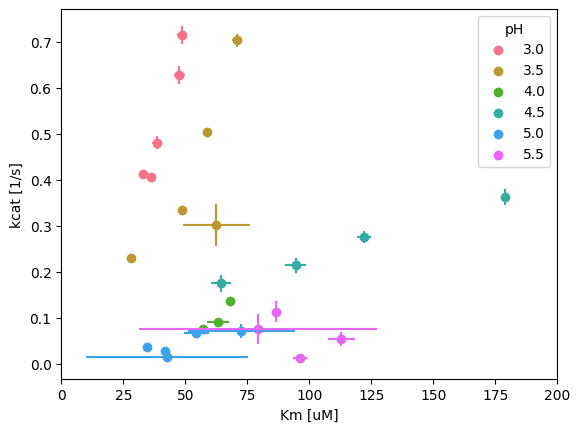

In [18]:
ph_map = sns.color_palette("husl")
ph_colors = [ph_map[(x)] for x in np.arange(6)]
pH_dict = dict(zip([3.0, 3.5, 4.0, 4.5, 5.0, 5.5], ph_colors))
pH_tuples = [pH_dict[x] for x in df["pH"].values]

temperature_map = matplotlib.cm.get_cmap('coolwarm')
colors = [temperature_map(x) for x in np.linspace(0,1,5)]
color_dict = dict(zip([25, 30, 35, 40 ,45], colors))
color_tuples = [color_dict[x] for x in df["temperature"]]

ax = plt.gca()
for i, (km, kcat, km_error, kcat_error, color, label) in enumerate(zip(df["Km [uM]"], df["kcat [1/s]"], df["Km stderr"], df["kcat stderr"], pH_tuples, df["pH"].values)):

    ax.scatter(km, kcat, color = color, label = label if not i % 5 else "")
    ax.errorbar(km, kcat, yerr=kcat_error,xerr=km_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "pH")
plt.ylabel("kcat [1/s]")
plt.xlabel("Km [uM]")
plt.xlim([0,200])


(0.0, 200.0)

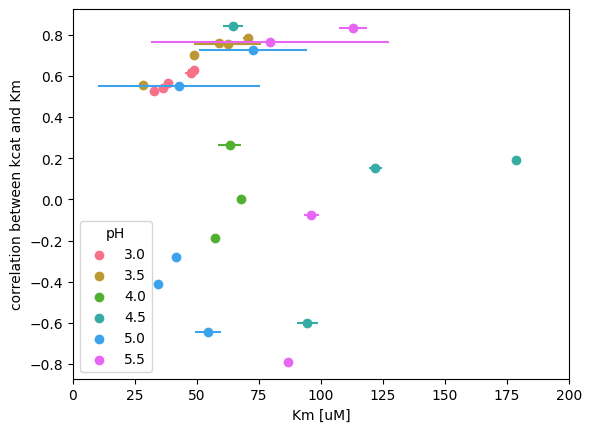

In [19]:
ax = plt.gca()
for i, (correlation, Km, km_error, kcat_error, color, label) in enumerate(zip(df["correlation kcat/Km"], df["Km [uM]"], df["Km stderr"], df["kcat stderr"], pH_tuples, df["pH"].values)):

    ax.scatter(Km, correlation, color = color, label = label if not i % 5 else "")
    ax.errorbar(Km, correlation, xerr=km_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "pH")
plt.ylabel("correlation between kcat and Km")
plt.xlabel("Km [uM]")
plt.xlim([0,200])

Text(0.5, 0, 'pH')

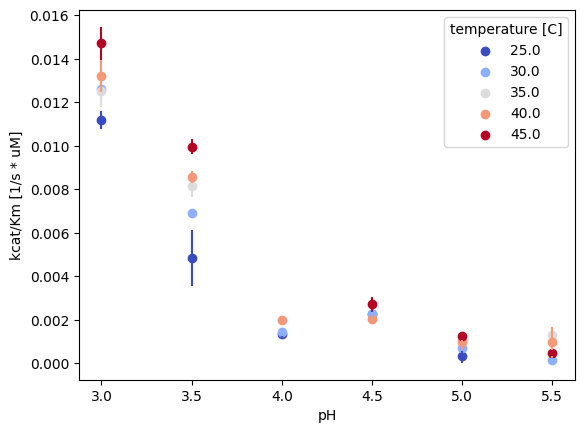

In [20]:
ax = plt.gca()
for i, (kcatkm, kcatkm_error, pH, color, label) in enumerate(zip(df["kcat/Km"], df["kcat/Km stderr"], df["pH"] , color_tuples, df["temperature"].values)):

    ax.scatter(pH, kcatkm, color = color, label = label if i in [0,1,2,3,4] else "")
    ax.errorbar(pH, kcatkm, yerr=kcatkm_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "temperature [C]")
plt.ylabel("kcat/Km [1/s * uM]")
plt.xlabel("pH")

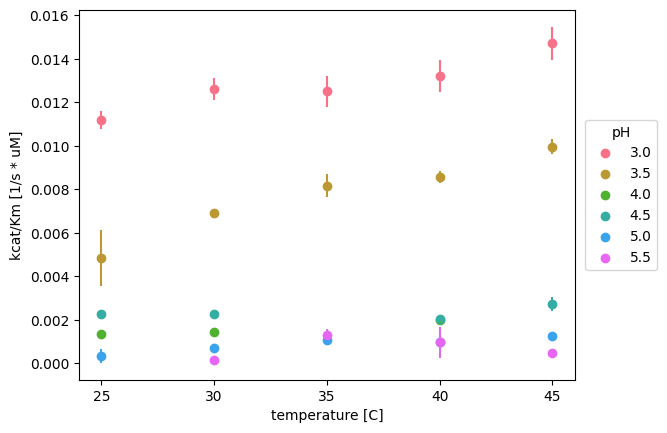

In [21]:
ax = plt.gca()
for i, (kcatkm, kcatkm_error, temp, color, label) in enumerate(zip(df["kcat/Km"], df["kcat/Km stderr"], df["temperature"] , pH_tuples, df["pH"].values)):

    ax.scatter(temp, kcatkm, color = color, label = label if not i %5 else "")
    ax.errorbar(temp, kcatkm, yerr=kcatkm_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "pH")
plt.ylabel("kcat/Km [1/s * uM]")
plt.xlabel("temperature [C]")
plt.xticks([25, 30, 35, 40, 45])
plt.legend(title = "pH", loc="center right", bbox_to_anchor=(1.18,0.5))

(0.0, 0.004)

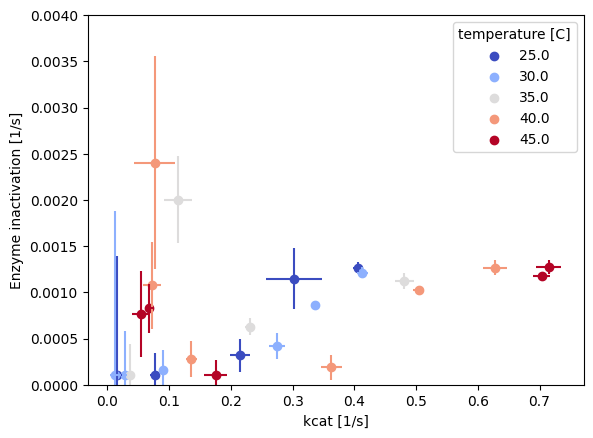

In [22]:
ax = plt.gca()
for i, (kcat, ki_error, kcat_error, ki, color, label) in enumerate(zip(df["kcat [1/s]"], df["Enzyme inactivation std"], df["kcat stderr"], df["Enzyme inactivation [1/s]"] , color_tuples, df["temperature"].values)):

    ax.scatter(kcat, ki, color = color, label = label if i in [0,1,2,3,4] else "")
    ax.errorbar(kcat, ki, yerr=ki_error, xerr=kcat_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "temperature [C]")
plt.ylabel("Enzyme inactivation [1/s]")
plt.xlabel("kcat [1/s]")
plt.ylim(0,0.004)

(0.0, 0.004)

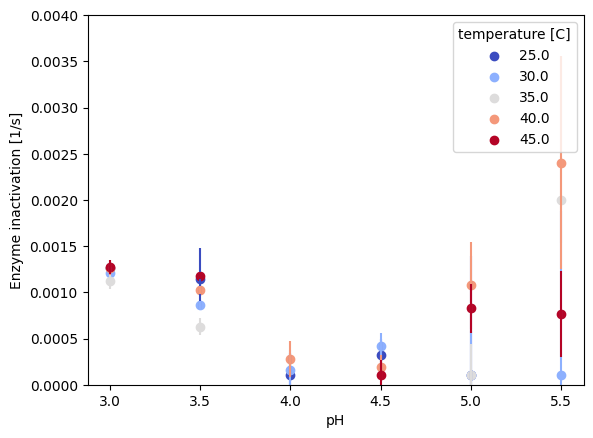

In [23]:
ax = plt.gca()
for i, (ph, ki_error, kcat_error, ki, color, label) in enumerate(zip(df["pH"], df["Enzyme inactivation std"], df["kcat stderr"], df["Enzyme inactivation [1/s]"] , color_tuples, df["temperature"].values)):

    ax.scatter(ph, ki, color = color, label = label if i in [0,1,2,3,4] else "")
    ax.errorbar(ph, ki, yerr=ki_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "temperature [C]")
plt.ylabel("Enzyme inactivation [1/s]")
plt.xlabel("pH")
plt.ylim(0,0.004)

(0.0, 0.004)

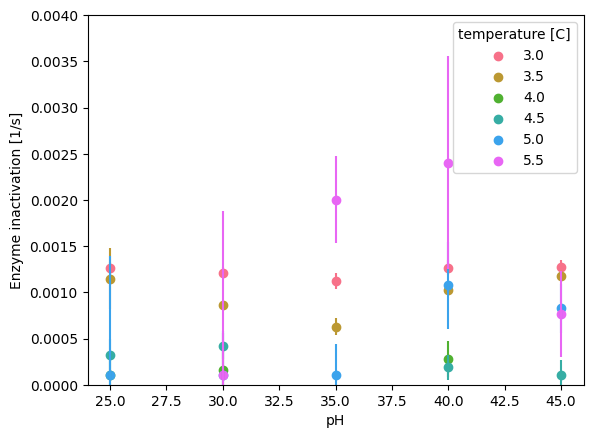

In [24]:
ax = plt.gca()
for i, (temp, ki_error, kcat_error, ki, color, label) in enumerate(zip(df["temperature"], df["Enzyme inactivation std"], df["kcat stderr"], df["Enzyme inactivation [1/s]"] , pH_tuples, df["pH"].values)):

    ax.scatter(temp, ki, color = color, label = label if not i%5 else "")
    ax.errorbar(temp, ki, yerr=ki_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "temperature [C]")
plt.ylabel("Enzyme inactivation [1/s]")
plt.xlabel("pH")
plt.ylim(0,0.004)

Text(0.5, 0, 'kcat [1/s]')

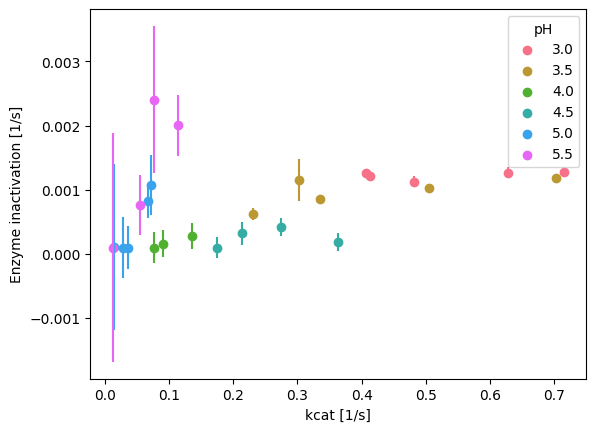

In [25]:
ax = plt.gca()
for i, (kcat, kcat_error, ki, color, label) in enumerate(zip(df["kcat [1/s]"], df["Enzyme inactivation std"], df["Enzyme inactivation [1/s]"] , pH_tuples, df["pH"].values)):

    ax.scatter(kcat, ki, color = color, label = label if not i%5 else "")
    ax.errorbar(kcat, ki, yerr=kcat_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "pH")
plt.ylabel("Enzyme inactivation [1/s]")
plt.xlabel("kcat [1/s]")

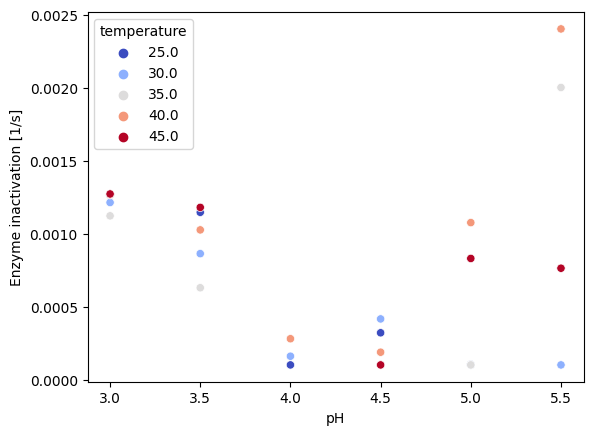

In [26]:
sns.scatterplot(data=df, x="pH", y="Enzyme inactivation [1/s]", hue="temperature", palette=sns.color_palette("coolwarm", as_cmap=True))
plt.show()

<AxesSubplot: >

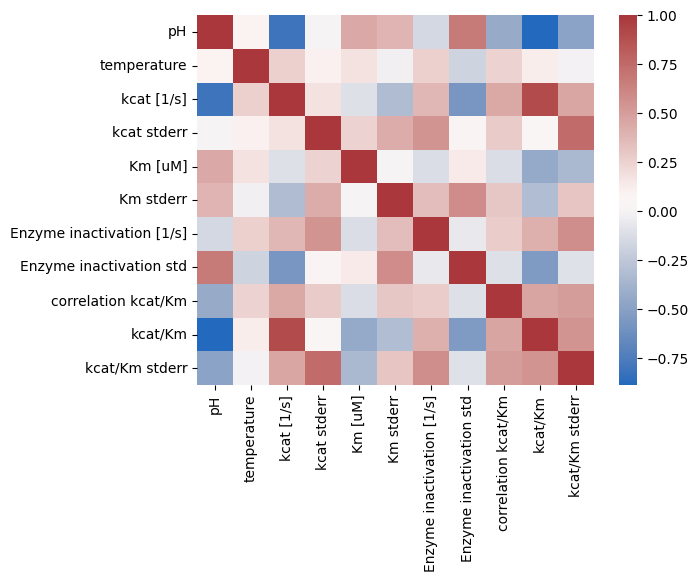

In [27]:
corr = df.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap = sns.color_palette("vlag", as_cmap=True))
#plt.xticks(rotation=45) 



<AxesSubplot: >

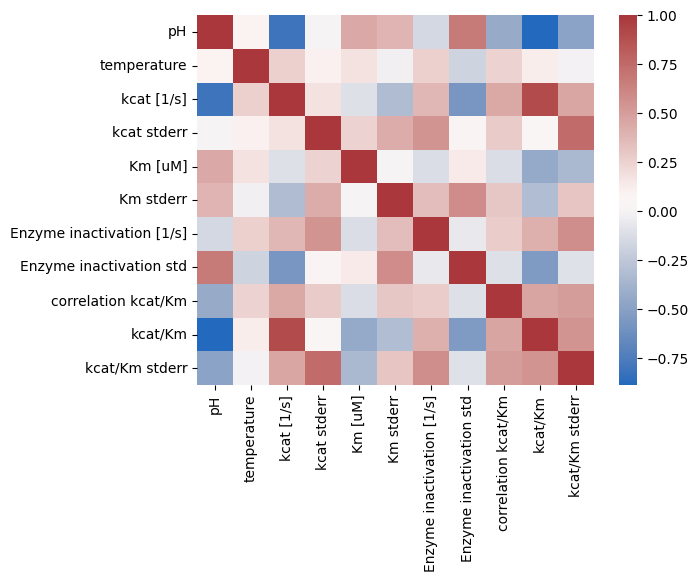

In [28]:
corr = df.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap = sns.color_palette("vlag", as_cmap=True))
#plt.xticks(rotation=45) 


## Delete all parameters above 5

In [29]:
results = sorted(results, key=lambda x: (x.data.pH, x.data.temperature))

# Get kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
ki = []
ki_std = []
pH = []
temperature = []
corr_kcat_km = []
for result in results:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)

    ki.append(params["K_ie"].value)
    ki_std.append(params["K_ie"].stderr)    

    
    correlation = params["k_cat"].correl
    if correlation == None:
        corr_kcat_km.append(float("nan"))
    else:
        corr_kcat_km.append(correlation["Km"])

    pH.append(result.data.pH)
    temperature.append(result.data.temperature)

df = pd.DataFrame.from_dict({
    'pH':pH, 
    "temperature":temperature, 
    'kcat [1/s]':kcat, 
    "Enzyme inactivation [1/s]":ki,
    'Km [uM]':Km,
    "correlation kcat/Km":corr_kcat_km,
    'Km stderr':Km_std,
    'kcat stderr':kcat_std,
    "Enzyme inactivation std":ki_std,})

df["kcat/Km"] = df["kcat [1/s]"] / df["Km [uM]"]
#kcat_km_stderr =((df["kcat stderr"]/df["kcat [1/s]"])**2+(df["Km stderr"]/df["Km [uM]"])**2)**0.5 * df["kcat/Km"]
#df["kcat/Km stderr"] = kcat_km_stderr



df = df.drop(index=25) # reached parameter boundaries --> inactive
df = df.drop(index=12) #Km really high stddev
df = df.drop(index=17) #kcat outlier
df = df.drop(index=14) #kcat outlier

df = df.loc[:19]
df


,pH,temperature,kcat [1/s],Enzyme inactivation [1/s],Km [uM],correlation kcat/Km,Km stderr,kcat stderr,Enzyme inactivation std,kcat/Km
0,3.0,25.0,0.406159,0.001265,36.288647,0.541905,1.138138,0.008299,0.000059,0.011192
1,3.0,30.0,0.413128,0.001214,32.800270,0.527223,1.089935,0.008922,0.000062,0.012595
2,3.0,35.0,0.481206,0.001122,38.492510,0.564576,1.856059,0.014997,0.000086,0.012501
3,3.0,40.0,0.627280,0.001267,47.526262,0.613903,2.244695,0.019536,0.000085,0.013199
4,3.0,45.0,0.714795,0.001272,48.630160,0.626224,2.102476,0.019960,0.000075,0.014699
5,3.5,25.0,0.302446,0.001147,62.467074,0.753684,13.512566,0.045085,0.000329,0.004842
6,3.5,30.0,0.335520,0.000863,48.645030,0.701485,1.228680,0.005747,0.000039,0.006897
7,3.5,35.0,0.231004,0.000629,28.304277,0.553633,1.539164,0.008448,0.000093,0.008161
8,3.5,40.0,0.504313,0.001026,58.833071,0.757641,1.572366,0.009169,0.000039,0.008572
9,3.5,45.0,0.703231,0.001180,70.665096,0.783479,2.016707,0.013575,0.000041,0.009952


In [30]:
rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

NameError: name 'pearsonr' is not defined

In [ ]:
corr = df.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap = sns.color_palette("vlag", as_cmap=True))
#plt.xticks(rotation=45) 

: 

In [ ]:
ax = plt.gca()
for i, (correlation, Km, km_error, color, label) in enumerate(zip(df["correlation kcat/Km"], df["Km [uM]"], df["Km stderr"], pH_tuples, df["pH"].values)):

    ax.scatter(Km, correlation, color = color, label = label if not i % 5 else "")
    ax.errorbar(Km, correlation, xerr=km_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "pH")
plt.ylabel("correlation kcat - Km")
plt.xlabel("Km [uM]")
plt.xlim([0,200])
plt.title("correlation between kcat and Km")

: 

In [ ]:
ax = plt.gca()
for i, (kcat, ki_error, kcat_error, ki, color, label) in enumerate(zip(df["kcat [1/s]"], df["Enzyme inactivation std"], df["kcat stderr"], df["Enzyme inactivation [1/s]"] , color_tuples, df["temperature"].values)):

    ax.scatter(kcat, ki, color = color, label = label if i in [0,1,2,3,4] else "")
    ax.errorbar(kcat, ki, yerr=ki_error, xerr=kcat_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "temperature [C]")
plt.ylabel("Enzyme inactivation [1/s]")
plt.xlabel("kcat [1/s]")


: 

In [ ]:
ax = plt.gca()
for i, (ph, ki_error, kcat_error, ki, color, label) in enumerate(zip(df["pH"], df["Enzyme inactivation std"], df["kcat stderr"], df["Enzyme inactivation [1/s]"] , color_tuples, df["temperature"].values)):

    ax.scatter(ph, ki, color = color, label = label if i in [0,1,2,3,4] else "")
    ax.errorbar(ph, ki, yerr=ki_error, xerr=kcat_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "temperature [C]")
plt.ylabel("Enzyme inactivation [1/s]")
plt.xlabel("pH")
plt.xticks([3,3.5,4,4.5])


: 

In [ ]:
fig, axes = plt.subplots(6,5, figsize=(12.5, 15), sharey=True, sharex=True)
for i, (doc, ax) in enumerate(zip(results, axes.flatten())):
    ph = doc.data.pH
    if not i%5:
        ax.set_ylabel("ABTS [uM]")
    doc.visualize(ax=ax, title = f"pH {doc.data.pH}, {doc.data.temperature}°C")
    if i in [25,26,27,28,29]:
        ax.set_xlabel("time [s]")
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="initial ABTS [uM]", bbox_to_anchor=(0.5,-0.04))
plt.tight_layout()

: 

### Effekt of calibration temperature and pH on kinetic parameters

In [ ]:
enzmldoc = enzmldoc_absorption_dict["3.0 45.0"]

standards_variations = list(filter(lambda x: x.calibration_data.pH == 3.0, standard_list))
[standards_variations.append(x) for x in list(filter(lambda x: x.calibration_data.temperature == 45 and x.calibration_data.pH < 6, standard_list))];


: 

In [ ]:
kinetics = []
for standard in standards_variations:
    print(copy.__file__)
    doc = copy.deepcopy(enzmldoc)
    standard.apply_to_EnzymeML(doc, species_id="s0", ommit_nan_measurements=True)
    kinetic = (ParameterEstimator.from_EnzymeML(doc, reactant_id="s0", measured_species="substrate"))
    kinetic.fit_models(enzyme_inactivation=True, only_irrev_MM=True)
    kinetics.append(kinetic)





: 

In [ ]:
# Get kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
ki = []
ki_std = []
temperature = [25,30,35,40,45,45,45,45,45,45,45]
pH = [3,3,3,3,3,3,3.5,4,4.5,5,5.5]
for result in kinetics:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)

    ki.append(params["K_ie"].value)
    ki_std.append(params["K_ie"].stderr)


df = pd.DataFrame.from_dict({
    'pH':pH, 
    "temperature":temperature, 
    'kcat [1/s]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [uM]':Km, 
    'Km stderr':Km_std, 
    "Enzyme inactivation [1/s]":ki,
    "Enzyme inactivation std":ki_std})

df["kcat/Km"] = df["kcat [1/s]"] / df["Km [uM]"]
kcat_km_stderr =((df["kcat stderr"]/df["kcat [1/s]"])**2+(df["Km stderr"]/df["Km [uM]"])**2)**0.5 * df["kcat/Km"]
df["kcat/Km stderr"] = kcat_km_stderr

: 

In [ ]:
df

: 

In [ ]:
ph_map = sns.color_palette("husl")
ph_colors = [ph_map[(x)] for x in np.arange(6)]
pH_dict = dict(zip([3.0, 3.5, 4.0, 4.5, 5.0, 5.5], ph_colors))
pH_tuples = [pH_dict[x] for x in df["pH"].values]

temperature_map = matplotlib.cm.get_cmap('coolwarm')
colors = [temperature_map(x) for x in np.linspace(0,1,5)]
color_dict = dict(zip([25, 30, 35, 40 ,45], colors))
color_tuples = [color_dict[x] for x in df["temperature"]]



ax = plt.gca()
for i, (kcatkm, kcatkm_error, temp, color, label) in enumerate(zip(df["kcat/Km"], df["kcat/Km stderr"], df["temperature"] , pH_tuples, df["pH"].values)):

    ax.scatter(temp, kcatkm, color = color, label = label if i in [5,6,7,8,9,10] else "")
    ax.errorbar(temp, kcatkm, yerr=kcatkm_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "pH")
plt.ylabel("kcat/Km [1/s * uM]")
plt.xlabel("temperature [C]")
plt.xticks([25, 30, 35, 40, 45])
plt.legend(title = "pH", loc="center right", bbox_to_anchor=(1.18,0.5))
plt.title("Dataset of pH 3 and 45°C calibrated with different standards")

: 

## Using linear calibration instead of 3rd polynominal model

In [ ]:
models = [None, "Linear"]
kinetics=[]
for model in models:
    print(copy.__file__)
    doc = copy.deepcopy(enzmldoc)
    standards_variations[4].apply_to_EnzymeML(doc, species_id="s0", ommit_nan_measurements=True, model_name=model)
    kinetic = (ParameterEstimator.from_EnzymeML(doc, reactant_id="s0", measured_species="substrate"))
    kinetic.fit_models(enzyme_inactivation=True, only_irrev_MM=True)
    kinetics.append(kinetic)

# Get kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
ki = []
ki_std = []
temperature = [45,45]
pH = [3,3]
for result in kinetics:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)

    ki.append(params["K_ie"].value)
    ki_std.append(params["K_ie"].stderr)


df = pd.DataFrame.from_dict({
    'pH':pH, 
    "temperature":temperature, 
    'kcat [1/s]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [uM]':Km, 
    'Km stderr':Km_std, 
    "Enzyme inactivation [1/s]":ki,
    "Enzyme inactivation std":ki_std})

df["kcat/Km"] = df["kcat [1/s]"] / df["Km [uM]"]
kcat_km_stderr =((df["kcat stderr"]/df["kcat [1/s]"])**2+(df["Km stderr"]/df["Km [uM]"])**2)**0.5 * df["kcat/Km"]
df["kcat/Km stderr"] = kcat_km_stderr

ph_map = sns.color_palette("husl")
ph_colors = [ph_map[(x)] for x in np.arange(6)]
pH_dict = dict(zip([3.0, 3.5, 4.0, 4.5, 5.0, 5.5], ph_colors))
pH_tuples = [pH_dict[x] for x in df["pH"].values]

temperature_map = matplotlib.cm.get_cmap('coolwarm')
colors = [temperature_map(x) for x in np.linspace(0,1,5)]
color_dict = dict(zip([25, 30, 35, 40 ,45], colors))
color_tuples = [color_dict[x] for x in df["temperature"]]

ax = plt.gca()
for i, (km, kcat, km_error, kcat_error, color, label) in enumerate(zip(df["Km [uM]"], df["kcat [1/s]"], df["Km stderr"], df["kcat stderr"], pH_tuples, df["pH"].values)):

    ax.scatter(km, kcat, color = color, label = label if not i % 5 else "")
    ax.errorbar(km, kcat, yerr=kcat_error,xerr=km_error, fmt=".", ecolor=color, markersize=0)
plt.legend(title = "pH")
plt.ylabel("kcat [1/s]")
plt.xlabel("Km [uM]")
plt.xlim([0,200])

: 

In [ ]:
subset_enzymeml = [copy.deepcopy(x) for x in enzmldoc_absorption_dict.values() if x.getReaction("r0").temperature == 45]
models = [None, "Linear"]
calibration_data = [x for x in standard_curve_dict.values() if x.calibration_data.temperature == 45 and x.calibration_data.pH < 6]
applied_model = {"best model": None, "Linear": "Linear"}

kinetics = []
model_names = []
for doc, standard in zip(subset_enzymeml, calibration_data):
    for name, value in applied_model.items():
        d = copy.deepcopy(doc)
        standard.apply_to_EnzymeML(d, species_id="s0", ommit_nan_measurements=True, model_name=value)
        kinetic = (ParameterEstimator.from_EnzymeML(d, reactant_id="s0", measured_species="substrate"))
        kinetic.fit_models(enzyme_inactivation=True, only_irrev_MM=True);
        kinetics.append(kinetic)
        kinetic.visualize()
        model_names.append(name)



model_names


: 

In [ ]:
print(len(kinetics))

: 

In [ ]:
kcat = []
kcat_std = []
Km = []
Km_std = []
ki = []
ki_std = []
temp = []
calibration_model = np.tile(np.array(["best model", "linear calibration"]), 6)
pH = np.repeat(np.array([3,3.5,4,4.5,5,5.5]), 2)
for result in kinetics:
    params = result.get_parameter_dict()
    temp.append(result.data.temperature)

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)

    ki.append(params["K_ie"].value)
    ki_std.append(params["K_ie"].stderr)


df = pd.DataFrame.from_dict({
    'pH':pH, 
    "calibration model":calibration_model, 
    'kcat [1/s]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [uM]':Km, 
    'Km stderr':Km_std, 
    "Enzyme inactivation [1/s]":ki,
    "temperature": temp,
    "Enzyme inactivation std":ki_std})

df["kcat/Km"] = df["kcat [1/s]"] / df["Km [uM]"]
kcat_km_stderr =((df["kcat stderr"]/df["kcat [1/s]"])**2+(df["Km stderr"]/df["Km [uM]"])**2)**0.5 * df["kcat/Km"]
df["kcat/Km stderr"] = kcat_km_stderr

df
        

: 

In [ ]:
ph_map = sns.color_palette("husl")
ph_colors = [ph_map[(x)] for x in np.arange(6)]
pH_dict = dict(zip([3.0, 3.5, 4.0, 4.5, 5.0, 5.5], ph_colors))
pH_tuples = [pH_dict[x] for x in df["pH"].values]

temperature_map = matplotlib.cm.get_cmap('coolwarm')
colors = [temperature_map(x) for x in np.linspace(0,1,5)]
color_dict = dict(zip([25, 30, 35, 40 ,45], colors))
color_tuples = [color_dict[x] for x in df["temperature"]]

cools = ["b", "orange", "b", "orange","b", "orange","b", "orange","b", "orange","b", "orange"]

ax = plt.gca()
for i, (kcatkm, kcatkm_error, temp, color, label) in enumerate(zip(df["kcat [1/s]"], df["kcat stderr"], df["pH"] , cools, df["calibration model"].values)):

    ax.scatter(temp, kcatkm, color = color, label = label if i in [0,1] else "")
    ax.errorbar(temp, kcatkm, yerr=kcatkm_error, fmt=".", color= color, markersize=0)
plt.legend(title = "calibration model")
plt.ylabel("kcat/Km [1/s * uM]")
plt.xlabel("pH")
plt.title("Datasets of various pHs and 45°C calibrated with different standard curve fits")

: 

In [ ]:
enzmldoc = concentration_enzymemldocs[4]

kinetics = ParameterEstimator.from_EnzymeML(enzmldoc, "s0", "substrate")
kinetics.fit_models(only_irrev_MM=True, enzyme_inactivation=False)
kinetics.visualize()

: 

- Redox potential of ABTS
- Higher pH values --> sulfonate groups are fully deprotonated. 